# Introduction
Every day, it is estimated that the world produces roughly 2.5 quintillion bytes of information, a large fraction of which is comprised of text data. These data come in the form of invoices, contracts, proposals, news articles, scientific journals, and ebooks among countless others sources. With such massive volumes of text being collected all the time, it's often impossible for a human to parse through all of it manually in an efficient way. As such, there is a great need for automated text processing methods to tag and cluster documents, extract meaning from them, and, in some cases, identify their sentiment.

The ability to process text automatically is especially important in the business setting, where product reviews and customer feedback are extremely valuable in helping shape a brand or product to better fit consumer needs. According to [this source](https://www.vendasta.com/blog/50-stats-you-need-to-know-about-online-reviews), approximately 80% of potential customers trust online reviews as much as personal recommendations from friends or family members, and a whopping 88% of them incorporate product reviews into their decision of whether or not they will ultimately purchase an item. Being able to quickly weed through and process thousands of comments and reviews to find out what people are saying about a product can give a business a significant advantage over their competitors.

In this project we'll check out some of the most commonly used methods of topic modeling and document clustering methods employed today. These include techniques like $n$-gram anlysis, part-of-speech tagging, term frequency$-$inverse document frequency, k-means clustering, and latent Dirichlet allocation. The text data used for this project consist of news article descriptions scraped from various sources around the world like The Guardian, Bloomberg, and the Associated Press, among many others. This project was heavily influenced by the excellent data science blog post written by Ahmed Besbes, which [can be found here](http://ahmedbesbes.com).

# Data Collection
To get the news article data that we'll use in this project, we can make use of the handy [newsapi.org](https://newsapi.org) API, which happens to be very simple to use. On the newsapi homepage, one will see a "GET API KEY" in the upper right-hand corner. After clicking this link, you'll be asked to proved an email address and a password...and that's all there is to it! Well, almost. You'll be presented with something called an "API key", which is a long series of numbers and letters. This is sort of like a password, and is unique to each individual user. To try the API, simply type:

https://newsapi.org/v1/articles?source={NEWSSOURCE}&apiKey={APIKEY}

in the search bar. Before doing so, however, replace {APIKEY} with your own API key, and replace {NEWSSOURCE} with a news source like Bloomberg. So our link would then become something like:

https://newsapi.org/v1/articles?source=bloomberg&apiKey=633qw20c29984ce08504f5c89c2cmm02

Note that in the above example, that particular API key does not work, but is just used to demonstrate how this would be done in practice. The output looks something like this:

In [32]:
import requests

site = 'https://newsapi.org/v1/articles?source=bloomberg&apiKey=636cf20c29984ce08504f5c89c2cee02'
source_data = requests.get(site, allow_redirects=True).json()
print(json.dumps(source_data, indent=2)[:1890])

{
  "status": "ok",
  "source": "bloomberg",
  "sortBy": "top",
  "articles": [
    {
      "author": "Terrence Dopp, Chris Strohm",
      "title": "Trump Keeps Controversies Smoldering With a Warning for Comey",
      "description": "President Donald Trump fired off warnings and barely veiled threats in a burst of morning tweets that raised new questions about the dismissal of former FBI Director James Comey and kept attention on the investigation of Russian political meddling.",
      "url": "https://www.bloomberg.com/politics/articles/2017-05-12/comey-should-hope-there-are-no-tapes-trump-tweets",
      "urlToImage": "https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iaIMBW8gh14g/v0/1200x675.jpg",
      "publishedAt": "2017-05-12T13:13:33.48Z"
    },
    {
      "author": "Alexis Leondis, Lynnley Browning",
      "title": "Trump Lawyers: Tax Returns Show Little Income From Russians",
      "description": "President Donald Trump\u2019s personal lawyers said his tax returns from the pas

Each output is a set of nested dictionaries with information regarding the

* Article source (Bloomberg in this case)
* Sortby (top, latest, or popular)
* Author
* Article title
* Article description
* Article url
* Article image url
* Date of publish

### Automatically Collecting the Data
One of the great things about newsapi is that this sort of data can be collected from over 70 news sources and blogs from various parts of the world, some of which are not even in english. In order to fetch the data like we've done above for many news sources, we need a way to automate the process. In general, the tasks we need to perform are:

* Loop over a bunch of new sources (e.g., Bloomberg, New York Times, etc.).
* For each news source, grab the top, latest, and popular articles.
* Get information from each article regarding title, description, url, etc.
* Save this data to a csv file for easy reading later on.

To this end, I wrote a Python module called scrapeNews.py to automatically perform the tasks listed above. I should note again that Ahmed Besbes' [data science blog](http://ahmedbesbes.com) was an outstanding source of information for how to do this.

In [69]:
import pandas as pd
import requests
import os.path
import csv

API_key = '633qw20c29984ce08504f5c89c2cmm02'
outdir = '/Users/degravek/Downloads/'

def articleType():
    sort_by = ['top', 'latest', 'popular']
    source_id = ['associated-press', 'bbc-news', 'bbc-sport', 'bloomberg', 'business-insider',
                 'cnbc', 'cnn', 'daily-mail', 'engadget', 'entertainment-weekly', 'espn',
                 'financial-times', 'fortune', 'four-four-two', 'fox-sports', 'google-news',
                 'hacker-news', 'mtv-news', 'national-geographic', 'new-scientist', 'newsweek',
                 'nfl-news', 'reuters', 'talksport', 'techcrunch', 'techradar', 'the-economist',
                 'the-guardian-uk', 'the-huffington-post', 'the-new-york-times', 'the-next-web',
                 'the-sport-bible', 'the-telegraph', 'the-verge', 'the-wall-street-journal',
                 'the-washington-post', 'time', 'usa-today', 'ars-technica', 'al-jazeera-english']
    return source_id, sort_by

def getCategories():
    site = 'https://newsapi.org/v1/sources'
    source_info = requests.get(site).json()

    source_categories = {}
    for element in source_info['sources']:
        source_categories[element['id']] = element['category']
    return source_categories

def writeData(output):
    df = pd.DataFrame(output, columns=['publishedAt', 'author', 'category', 'title',
                                        'description', 'url'])
    df = df.drop_duplicates(subset='url')

    file_name = outdir + 'news_articles.csv'
    if os.path.isfile(file_name):
        df.to_csv(file_name, mode='a', encoding='utf-8', index=False, header=False)
    else:
        df.to_csv(file_name, mode='a', encoding='utf-8', index=False, header=True)

def scrapeNews():
    source_id, sort_by = articleType()
    source_categories = getCategories()

    output = []
    for sid in source_id:
        for sb in sort_by:
            # Get news article json
            site = 'https://newsapi.org/v1/articles?source=' + sid + '&sortBy=' + \
                    sb + '&apiKey=' + API_key

            source_data = requests.get(site).json()

            try:
                for element in source_data['articles']:
                    if not element['author']: element['author'] = 'no_author'
                    output.append([element['publishedAt'], element['author'],
                                    source_categories[sid], element['title'],
                                    element['description'], element['url']])
            except:
                pass

    writeData(output)

if __name__ == '__main__':
    scrapeNews()

The code above might look daunting at first, but it's actually not so bad. At the top, I define my API key and the directory where my file containing news articles will be saved. The function articleType() defines which news sources we're interested in grabbing articles from. From these sources, scrapeNews() will then grab the top, latest, and popular articles.

Every news source available is given a "category" by newsapi. For example, Bloomberg is given a "general" tag as this source generally covers many different news topics, while ESPN is given a "sport" tag. One will note that in our example earlier, though, category was not a key in the dictionary. The categories for each source can be instead be found here:

https://newsapi.org/v1/sources

The function getCategories() loops over every possible news source and grabs the corresponding category from the list. The result is a dictionary where the first ten entries look something like this:

In [67]:
site = 'https://newsapi.org/v1/sources'
source_info = requests.get(site).json()

source_categories = {}
for element in source_info['sources']:
    source_categories[element['id']] = element['category']

dict(zip(list(source_categories.keys())[:10], list(source_categories.values())[:10]))

{'abc-news-au': 'general',
 'al-jazeera-english': 'general',
 'ars-technica': 'technology',
 'associated-press': 'general',
 'bbc-news': 'general',
 'bbc-sport': 'sport',
 'bild': 'general',
 'bloomberg': 'business',
 'breitbart-news': 'politics',
 'business-insider': 'business'}

The function scrapeNews() then loops over each news source we've decided to use, finds its coresponding category using the dictionary above, and then grabs all the relevant news article information from that source using our API key.

Because we're collecting the top, latest, and popular articles for each source, there are bound to be duplicate articles included when we're done. Therefore, before writing the data to file, we drop duplicate entries based on the article url column. All of this is done in writeData().

### The Cron Job
We can run scrapeNews.py easily by calling **python scrapeNews.py** from the terminal command line. One will notice though that the number of news articles scraped after this run is only on the order of a few hundred or so $-$ not nearly enough for our purposes. We could manually run the code every 15 minutes or so, but that would be pretty tedious. To get around this, we can set up something called a "cron job" to execute the script for us automatically over fixed time intervals.

Setting up a cron job is pretty easy. In our case (working on a Mac), we need to follow three steps:

1. **cd** to where scrapeNews.py is located and type **chmod +x scrapeNews.py** to make the file executable
2. From the terminal command line, type **crontab -e**
3. In this prompt, enter the information regarding when the code will run (described below)
4. Type (if using nano) **control + o** to save the changes, then **control + x** to exit

For step (3), the input will look something like:

\* \* \* \* \* ~/anaconda/bin/python /Users/degravek/Site/news/scrapeNews.py

The second term in the line above (~/anaconda/bin/python) is the path to my python distribution, while the third term (/Users/degravek/Site/news/scrapeNews.py) is the absolute path to where scrapeNews.py is located. The five asterisks are palceholders that determine how frequently you want the code to be run, and their meaning is described well by the diagram below.

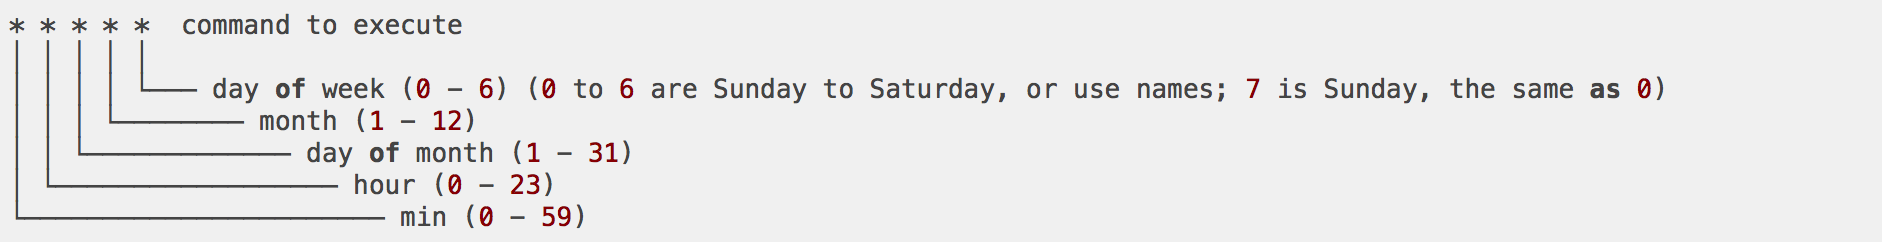

For this project, I ran scrapeNews.py every 15 minutes for a several days, so my input looked like

\*/15 \* \* \* \* ~/anaconda/bin/python /Users/degravek/Site/news/scrapeNews.py

When enough data has been collected, simply type **control -r** in the terminal command line to stop the cron job.

Okay, now let's start looking at the data! Before we get started, let's import some useful Python libraries that will come in handy later.

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from collections import Counter
from string import punctuation
import pandas as pd
import numpy as np
import nltk
import re

import matplotlib.pyplot as mp
%matplotlib inline

from plotly.offline import download_plotlyjs
from plotly.offline import init_notebook_mode
from plotly.offline import plot, iplot
import cufflinks as cf

cf.go_offline()

stoplist = stopwords.words('english')

We now load in the csv containing the news article data, and drop any duplicates that may have gotten through.

In [115]:
df = pd.read_csv('/Users/degravek/Downloads/news_articles.csv')

df = df.drop_duplicates(subset='url')
df = df.drop_duplicates(subset='title')
df = df.reset_index(drop=True)
df = df[df['description'].notnull()].reset_index(drop=True)

df.loc[df['category'] == 'science-and-nature', 'category'] = 'science-nature'

 Let's see what the data look like.

In [3]:
df.head()

publishedAt    author category  \
0  2017-05-10T23:08:03+00:00  BBC News  general   
1  2017-05-10T22:49:14+00:00  BBC News  general   
2  2017-05-10T21:32:54+00:00  BBC News  general   
3  2017-05-10T19:22:46+00:00  BBC News  general   
4  2017-05-10T18:39:07+00:00  BBC News  general   

                                               title  \
0  General election 2017: Labour manifesto draft ...   
1  Trump 'considered firing Comey since taking of...   
2  Trump Russia meeting: Lavrov praises Trump and...   
3  Drayton Manor: Park to stay closed after Evha ...   
4  Women charged with terror offences and conspir...   

                                         description  \
0  The document includes plans to nationalise par...   
1  Democratic senators say the FBI director was s...   
2  Russia's foreign minister said the talks were ...   
3  Drayton Manor Theme Park will shut for a secon...   
4  A woman shot in a police raid is among three c...   

                                                 url  
0     http://www.bbc.co.uk/news/uk-politics-39877439  
1  http://www.bbc.co.uk/news/world-us-canada-3987...  
2  http://www.bbc.co.uk/news/world-us-canada-3987...  
3  http://www.bbc.co.uk/news/uk-england-stoke-sta...  
4              http://www.bbc.co.uk/news/uk-39878398

As discussed earlier, we have collected the

* Publish date
* Author
* Category
* Article itle
* Article Description
* Article url

We can check out the distribution of categories. I use plotly and cufflinks to do this, as they produce nice interactive figures with functions call similar to Pandas.

In [4]:
df['category'].value_counts().iplot(kind="bar", xTitle='Category', color='blue',
                            yTitle='Counts', dimensions=(790,550), margin=(100,100,60,0))

In all, the news articles fall into seven categories:

* General
* Technology
* Business
* Sport
* Entertainment
* Science & Nature
* Music

General is sort of a catch-all category (often containing political and world news), and therefore has many more articles than the other categories. There are also more of these types of news sources that we've included in scrapeNews.py. Among the seven categories, we see that the Science & Nature and Music make up a small fraction of the total number of articles. Let's take a look at example article descriptions for some of these categories.

In [8]:
for category in set(df['category']):
    print('Category:', category)
    print(df[df['category'] == category]['description'].tolist()[0])
    print('--------------------')

Category: technology
Tesla’s mission is to accelerate the world’s transition to a sustainable energy future by creating products that are so compelling, there is no alternative. Solar energy has always been part of our master plan, and we recognized the need for a roof that is simultaneously affordable, durable, beautiful and integrated with battery storage.
--------------------
Category: general
The Senate intelligence committee Wednesday issued a subpoena to former National Security Adviser Michael Flynn for documents regarding his interactions with Russian officials.
--------------------
Category: sport
OAKLAND, Calif. (AP)  Andrew Triggs overcame a shaky start to pitch six innings, Chad Pinder homered and the Oakland Athletics held on to beat the Los Angeles Angels 3-1 on Wednesday.
--------------------
Category: business
Senior Senate Republicans closed ranks behind President Donald Trump Wednesday after his dismissal of FBI Director James Comey, rejecting calls for a special pros

Alright, let's get to the modeling! We'll start with $n$-gram analysis.

# $n$-Gram Analysis
The method of $n$-gram analysis is one of the most common types of topic modeling techniques employed today. By $n$-gram analysis, I mean examining combinations of $n$ sequential words in a sentence. For example, the 1-grams (called unigrams) and 2-grams (called bigrams) of the sentence *"this is an example of a sentence"* would be:

* Unigrams: this, is, an, example, of, a, sentence
* Bigrams: this is, is an, an example, example of, of a, a sentence

In the first case, the unigrams are just a list of all single words in the sentence. In the second case, the bigrams are all sequential two-word combinations.

By looking at which $n$-grams occur most frequently in a document, we can get a sense for what is being talked about. In python, the $n$-grams can be computed in two ways $-$ manually using a function that we define ourselves, or automatically using Python Learn's CountVectorizer method. Let's try both!

Before the $n$-grams can be computed, we first have to process the text a little bit to remove puctuation and stop words. Stop words are words that occur so frequently in normal speech that they're of little interest to us. These include words like "the", "and", etc. We can define two functions below to perform these tasks $-$ they're called processText and rmStopwords. A third function called nGrams takes in some text, tokenizes it (i.e., splits it into its individual words) and finds the $n$ sequential word combinations. In this manual implementation, we can also perform an additional task that is helpful in identifying interesting words. If we're finding unigrams, the function tags the part of speech of each word and keeps only nouns, which are more likely to be the subject of a piece of text.

In [6]:
punctuation = '!"#?$%“”&\'()’*+,./:;<=>@[\\]^_`{|}~…' #(removed - symbol)
def processText(text):
    result = text.lower()
    result = ''.join(word for word in result
                    if word not in punctuation)
    result = re.sub(r' +', " ", result).strip()
    return result

def rmStopwords(text):
    result = text.lower().split()
    result = ' '.join(word for word in result
                      if word not in stoplist)
    result = re.sub(r' +', " ", result).strip()
    return result

def nGrams(text, n):
    result = []
    text = text.split()
    if n==1:
        partspeech = nltk.pos_tag(text)
        result = [word for word, pos in
                  partspeech if pos[0] == 'N']
    else:
        for i in range(len(text)-(n-1)):
            result.append(' '.join(text[i:i+n]))
    if not result:
        result = np.nan
    return result

With these functions defined, we can now process the text and compute $n$-grams. In processing the text, we keep only those news articles where the description has more than 140 characters, as shorter descriptions sometimes don't contain a lot of useful information and generally add noise when performing topic modeling.

In [116]:
df['pro_descr'] = df['description'].apply(rmStopwords).apply(processText)
df['num_chars'] = df['pro_descr'].apply(len)

df = df[df['num_chars'] > 140].reset_index(drop=True)

df['ngram_1']   = df['pro_descr'].apply(nGrams, args=(1,))
df['ngram_2']   = df['pro_descr'].apply(nGrams, args=(2,))
df['ngram_3']   = df['pro_descr'].apply(nGrams, args=(3,))

Let's look at the unigrams, bigrams, and trigrams.

In [95]:
df[['description','ngram_1','ngram_2','ngram_3']].head()

description  \
0  Senior Senate Republicans closed ranks behind ...   
1  At the moment, the criminal probe into Russia’...   
2  Aetna Inc. will leave the few remaining states...   
3  The city of Portland, Oregon, is starting its ...   
4  United Continental Holdings Inc. directors wer...   

                                             ngram_1  \
0  [senate, republicans, ranks, president, donald...   
1  [moment, probe, russias, meddling, election, s...   
2  [aetna, inc, states, plans, year, health, insu...   
3  [city, portland, oregon, investigation, uber, ...   
4  [continental, holdings, directors, pension, fu...   

                                             ngram_2  \
0  [senior senate, senate republicans, republican...   
1  [moment criminal, criminal probe, probe russia...   
2  [aetna inc, inc leave, leave remaining, remain...   
3  [city portland, portland oregon, oregon starti...   
4  [united continental, continental holdings, hol...   

                                             ngram_3  
0  [senior senate republicans, senate republicans...  
1  [moment criminal probe, criminal probe russias...  
2  [aetna inc leave, inc leave remaining, leave r...  
3  [city portland oregon, portland oregon startin...  
4  [united continental holdings, continental hold...

We can now see which $n$-grams occur most frequently in each category.

In [10]:
def keywords_ngram(category, n, num):
    text = df[df['category'] == category]['ngram_' + str(n)]
    result = []
    for word_list in text:
        result += word_list
    return Counter(result).most_common(num)

for category in set(df['category']):
    print("Category:", category)
    print("1-grams:", keywords_ngram(category, 1, 10))
    print('--------------------')
    print("2-grams:", keywords_ngram(category, 2, 10))
    print('--------------------')
    print("3-grams:", keywords_ngram(category, 3, 10))
    print('--------------------')

Category: technology
1-grams: [('today', 33), ('company', 14), ('software', 14), ('windows', 14), ('conference', 12), ('system', 12), ('design', 12), ('users', 12), ('week', 10), ('reality', 10)]
--------------------
2-grams: [('windows 10', 9), ('mixed reality', 6), ('build conference', 5), ('conference seattle', 5), ('today announced', 4), ('snap inc', 3), ('first quarter', 3), ('ability behave', 3), ('behave randomly', 3), ('microsofts build', 3)]
--------------------
3-grams: [('ability behave randomly', 3), ('microsofts build conference', 3), ('build conference seattle', 3), ('windows mixed reality', 3), ('ended march 31', 2), ('listing hypothetical results', 2), ('youve probably heard', 2), ('premiumstech hub health', 2), ('hub health tips', 2), ('health tips science', 2)]
--------------------
Category: general
1-grams: [('president', 117), ('director', 69), ('james', 61), ('thursday', 60), ('trump', 55), ('friday', 46), ('house', 42), ('donald', 41), ('election', 40), ('fbi', 38

Now let's perform the same exercise, but using Scikit-Learn's CountVectorizer instead.

In [11]:
def keywords_cvec(category, n, num):
    text = df[df['category'] == category]['pro_descr']

    vector = CountVectorizer(min_df=1, strip_accents='unicode', analyzer='word',
                     token_pattern=r'\w{1,}', ngram_range=(n,n), stop_words=stoplist)
    cvec = vector.fit_transform(text)

    feature_names = vector.get_feature_names()
    feature_count = cvec.toarray().sum(axis=0)
    sort_feature = sorted(zip(feature_names, feature_count), key=lambda x: x[1], reverse=True)[:num]
    return sort_feature

In [12]:
for category in set(df['category']):
    print("Category:", category)
    print("1-grams:", keywords_cvec(category, 1, 10))
    print('--------------------')
    print("2-grams:", keywords_cvec(category, 2, 10))
    print('--------------------')
    print("3-grams:", keywords_cvec(category, 3, 10))
    print('--------------------')

Category: technology
1-grams: [('today', 33), ('new', 30), ('microsoft', 27), ('windows', 23), ('one', 20), ('first', 19), ('build', 17), ('two', 15), ('announced', 14), ('company', 14)]
--------------------
2-grams: [('windows 10', 9), ('mixed reality', 6), ('build conference', 5), ('conference seattle', 5), ('today announced', 4), ('ability behave', 3), ('basic income', 3), ('behave randomly', 3), ('boring company', 3), ('city council', 3)]
--------------------
3-grams: [('ability behave randomly', 3), ('build conference seattle', 3), ('microsofts build conference', 3), ('windows mixed reality', 3), ('alameda county sheriffs', 2), ('big fours congressional', 2), ('build developers conference', 2), ('california highway patrol', 2), ('car give commands', 2), ('congressional lobbying activity', 2)]
--------------------
Category: general
1-grams: [('said', 138), ('president', 121), ('thursday', 113), ('us', 113), ('friday', 102), ('trump', 89), ('director', 69), ('fbi', 68), ('donald', 6

We see that in the business category, for example, many news articles tend to focus a great deal on Donald Trump, former FBI director James Comey, and former director of the Defense Intelligence Agency Michael Flynn. Let's plot the ten most frequent trigrams.

In [13]:
ngram = pd.DataFrame(keywords_ngram('general', 3, 10), columns=['ngram_3','counts'])

plot = ngram.iplot(kind="bar", x='ngram_3', y='counts', xTitle='Trigrams', color='blue',
                            yTitle='Counts', dimensions=(790,550), margin=(80,120,110,20))

Another common method used in topic modeling is called noun-phrase chunking. The idea is to find nouns and surrounding descriptive words in the text, as these phrases often carry the main point (i.e., the topic) of a sentence. I was first introduced to the idea of chunking from [this super informative article](http://bdewilde.github.io/blog/2014/09/23/intro-to-automatic-keyphrase-extraction/) about topic modeling.

To perform chunking, the first thing we have to do is define a "chunking pattern" (this is the string of symbols in the function argument). The chunking pattern tells the function which sort of phrases to look for in the text. In our case, it's one or more optional adjectives followed by one or more nouns.

In [14]:
def extract_candidate_chunks(text, grammar = 'CHUNK: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'):
    import itertools, nltk, string
    parser = nltk.RegexpParser(grammar)
    tagged_sents = [nltk.pos_tag(nltk.word_tokenize(text))]

    for chunk in tagged_sents:
        if not chunk:
            candidates = []
        else:
            candidates = []
            tree = parser.parse(chunk)
            for subtree in tree.subtrees():
                if subtree.label() == 'CHUNK':
                    candidates.append((' '.join([word for (word, tag) in subtree.leaves()])))
    candidates = [word for word in candidates if word not in stoplist]
    return candidates

Now we'll define another function to count common chunks.

In [15]:
def keyphrases_chunk(category, num):
    tokens = df[df['category'] == category]['chunk']
    
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(num)

Let's try it out!

In [16]:
df['chunk'] = df['pro_descr'].apply(extract_candidate_chunks)

for category in set(df['category']):
    print("Category:", category)
    print("chunk:", keyphrases_chunk(category, 15))
    print('--------------------')

Category: technology
chunk: [('today', 9), ('users', 6), ('years', 5), ('google', 5), ('day', 5), ('people', 4), ('company', 4), ('percent', 3), ('ability', 3), ('microsofts', 3), ('something', 3), ('conference', 3), ('year', 3), ('post', 3), ('windows', 3)]
--------------------
Category: general
chunk: [('thursday', 25), ('fbi director james', 22), ('united states', 18), ('president', 16), ('president donald', 14), ('people', 14), ('trump', 13), ('years', 12), ('friday', 12), ('white house', 11), ('election', 9), ('wednesday', 8), ('james', 7), ('deputy attorney', 7), ('general rod rosenstein', 7)]
--------------------
Category: sport
chunk: [('points', 11), ('goals', 10), ('games', 9), ('summer', 8), ('champions', 6), ('talksport', 6), ('matches', 6), ('host manchester', 6), ('manchester', 5), ('teams', 5), ('season', 5), ('tottenham hotspur bid', 5), ('white hart lane', 5), ('final game', 5), ('grand old stadium', 5)]
--------------------
Category: business
chunk: [('president donal

We see that chunking also does a pretty good job in grabbing the main topics of the text. The results are similar to the mixture of unigrams, bigrams, and trigrams found using $n$-gram analysis, but they also contain longer, more informative strings like "crash hillside near medellin international airport colombia" and "former federal bureau investigation director james".

# Term Frequency$-$Inverse Document Frequency
One very popular method used in clustering documents and in isolating "important" words within those documents is called term frequency$-$inverse document frequency (abbreviated tf-idf). The idea behind tf-idf is that a word is deemed "important" if it occurs frequently within a single document (i.e., a news article description), but is less important if it occurs many times across *several* documents. In this way, words common to many documents like "the", "and", etc. are given a lower tf-idf score and are therefore not very important.

How can we represent tf-idf mathematically, though? To compute a tf-idf score of a term, the name itself suggests that we might count the number of times the term appears in a document (term frequency), and weight it by the number of times it occurs across all documents (inverse document frequency). Mathematically, this is written as

$$tfidf = tf(t,d) \times idf(t,D),$$

Where $tf(t,d)$ is the frequency of some term $t$ in document $d$, and $idf$ is the inverse document frequency of term $t$ across all documents $D$, given as

$$idf(t,D) = log\frac{\big|D\big|}{1+\big|\{d\in D:t\in d\}\big|}$$

Luckily for us, Python's Scikit$-$Learn has a built in method for doing this called TfidfVectorizer. We feed in the processed article descriptions (punctuation and stopwords removed).

In [107]:
tfidf = TfidfVectorizer(min_df=10, max_features=10000, strip_accents='unicode',
                           analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2),
                           use_idf=1, smooth_idf=1, sublinear_tf=1)

tfidf_descr = tfidf.fit_transform(df['pro_descr'])

In [108]:
tfidf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
tfidf_df = pd.DataFrame(tfidf.idf_, index=tfidf.get_feature_names(), columns=['tfidf_val'])
tfidf_df.sort_values('tfidf_val', ascending=False, inplace=True)

Let's look at some of the unigrams and bigrams deemed most important through tf-idf.

In [109]:
tfidf_df.head(10)

tfidf_val
lawmakers        6.463061
founder          6.463061
really           6.463061
era              6.463061
banks            6.463061
emerged          6.463061
bears            6.463061
related          6.463061
elect emmanuel   6.463061
beginning        6.463061

In [110]:
print(tfidf_descr.shape)

(2593, 1198)


Performing tf-idf has converted each article description into a 498 demensional vector. For plotting purposes, let's reduce the dimensionality using truncated singular value decomposition and t-distributed stochastic neighbor embedding (TSNE). TSNE is a really cool technique for preserving "distances" between the tf-idf vectors while at the same time reducing their dimensionality. This is often useful in clustering.

In [111]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(tfidf_descr)

In [112]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, learning_rate=1500)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2593
[t-SNE] Computed conditional probabilities for sample 2000 / 2593
[t-SNE] Computed conditional probabilities for sample 2593 / 2593
[t-SNE] Mean sigma: 0.117414
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.035431
[t-SNE] Error after 200 iterations: 1.035431


In [113]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['description'] = df['description']
tfidf_df['category'] = df['category']

In [114]:
tfidf_df.iplot(kind="scatter", x='x', y='y', mode='markers', size=5, text='description',
              dimensions=(790,650), margin=(50,50,40,40), color='blue')

We see that tf-idf does a fairly good job of clustering similar topics. For example there are clusters which discuss Donald Trump and James Comey, a cluster discussing sports, one discussing technology, etc.

# k$-$Means Clustering

In [102]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = 10

kmeans_model = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', n_init=100,
                               batch_size=100, verbose=False, max_iter=1000, random_state=3)

kmeans = kmeans_model.fit(tfidf_descr)
kmeans_clusters = kmeans.predict(tfidf_descr)
kmeans_distances = kmeans.transform(tfidf_descr)

In [117]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()

for i in range(n_clusters):
    print("Cluster %d:" % i)
    for ind in sorted_centroids[i, :10]:
        print(terms[ind], end=' / ')
    print('\n', '--------------------')

Cluster 0:
cup / director james / dozens / changing / debate / california / details / hear / deputy / android / 
 --------------------
Cluster 1:
gold / a / first / general election / decision / held / debate / charges / evening / advantage / 
 --------------------
Cluster 2:
france / everton / evidence / general election / black / full / england / caused / current / discuss / 
 --------------------
Cluster 3:
chelsea / app / chelseas / fans / family / building / fall / days / 22 / court / 
 --------------------
Cluster 4:
conservative / chance / great / games / 14 / dont / debate / get / all / companies / 
 --------------------
Cluster 5:
body / earnings / bank / anyone / chinese / fund / boss / based / chris / banks / 
 --------------------
Cluster 6:
calls / everton / first quarter / every / gave / gas / act / arsenal / attacks / general election / 
 --------------------
Cluster 7:
cover / growth / french / alex / 6 / 1 / find / debate / chinas / apps / 
 --------------------
Cluste

In [118]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, learning_rate=500)
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

df_kmeans = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
df_kmeans['cluster'] = kmeans_clusters
df_kmeans['description'] = df['description']
df_kmeans['category'] = df['category']

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 977 / 977
[t-SNE] Mean sigma: 0.020537
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.944959
[t-SNE] Error after 425 iterations: 0.944959


In [119]:
colormap = ["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9",
            "#68af4e", "#6e6cd5", "#e3be38", "#4e2d7c", "#5fdfa8"]

color_dict = dict(zip(range(0,10), colormap))

df_kmeans['color'] = df_kmeans['cluster'].map(color_dict)

In [120]:
#df_kmeans.iplot(kind="scatter", x='x', y='y', mode='markers', size=5, text='description',
#dimensions=(750,650), margin=(0,0,0,0))

import plotly.graph_objs as go

trace = go.Scatter(
    y = df_kmeans['y'],
    x = df_kmeans['x'],
    mode = 'markers',
    text = df['description'],
    marker = dict(size='5', color=df_kmeans['color'].tolist())
    )

df_kmeans.iplot([trace], dimensions=(790,650), margin=(50,50,40,40))

In [91]:
tfidf_descr.shape

(977, 498)

<script>
  $(document).ready(function(){
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>